In [7]:
# Imports
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import time
import csv

In [9]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    σ = 10
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')/σ/σ
    #sq_norm = -0.5 * abs(xa-xb)
    return np.exp(sq_norm)

# Gaussian process posterior
def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

<IPython.core.display.Javascript object>


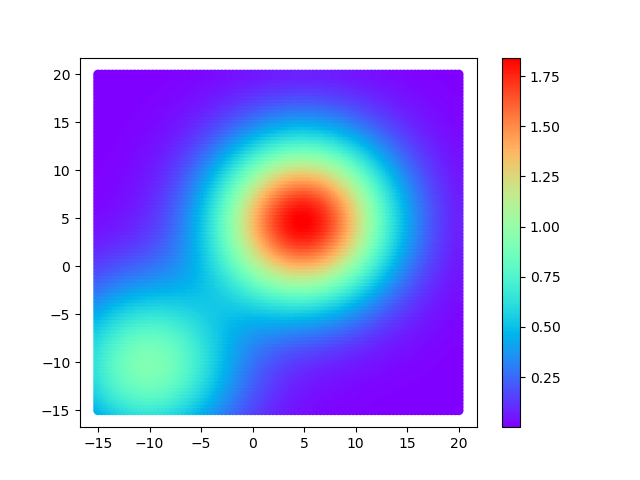

In [10]:
# Parameters
size = 100
real_data_size = size*size

sigma_x = 6.
sigma_y = 6.

template =  np.linspace(-15, 20, size)
my_mesh_x = np.zeros([size, size])
my_mesh_y = np.zeros([size, size])
my_data = np.zeros([real_data_size,2])

for i in range(size):
    for j in range(size):
        my_mesh_x[i][j] = template[j]
        my_mesh_y[i][j] = template[i]
        my_data[i*size+j][0]=template[j]
        my_data[i*size+j][1]=template[i]
        
shift_dist = 5
my_mesh_x_1 = my_mesh_x - shift_dist
my_mesh_y_1 = my_mesh_y - shift_dist
my_mesh_x_2 = my_mesh_x - shift_dist
my_mesh_y_2 = my_mesh_y - shift_dist
my_mesh_x_3 = my_mesh_x + 2*shift_dist
my_mesh_y_3 = my_mesh_y + 2*shift_dist

z1 = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(my_mesh_x_1**2/(2*sigma_x**2)
     + my_mesh_y_1**2/(2*sigma_y**2))))*1000/4.8
z2 = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(my_mesh_x_2**2/(2*sigma_x**2)
     + my_mesh_y_2**2/(2*sigma_y**2))))*1000/4.8
z3 = (1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(my_mesh_x_3**2/(2*sigma_x**2)
     + my_mesh_y_3**2/(2*sigma_y**2))))*1000/4.8

z = z1+z2+z3

# For Painting
my_draw_test_data_x = my_data[:,0].reshape(real_data_size,1)
my_draw_test_data_y = my_data[:,1].reshape(real_data_size,1)
z = z.reshape(real_data_size,1)

_min, _max = np.amin(z), np.amax(z)
fig, ax = plt.subplots()
sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=z, cmap='rainbow', vmin = _min, vmax = _max)
plt.colorbar()
plt.savefig("Magnetic_field_simulate.png")
plt.show()

<IPython.core.display.Javascript object>


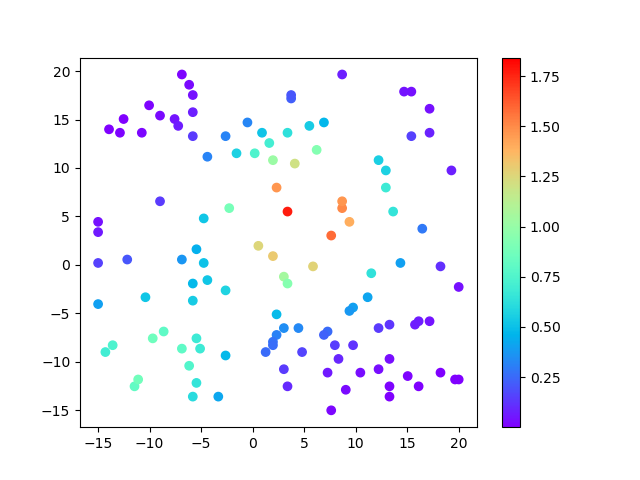

In [12]:
training_data_size = 121
# Generate 30 random index from 0~100
# sel_x_index = random.sample(range(real_data_size), training_data_size)
# sel_y_index = random.sample(range(real_data_size), training_data_size)
random_index = random.sample(range(real_data_size), training_data_size)

# Generate an empty Space for storage random data
my_training_data_xy = np.zeros([training_data_size, 2])
my_training_data_z = np.zeros(training_data_size)
for i in range(len(random_index)):
    my_training_data_xy[i][0] = my_data[random_index[i]][0]
    my_training_data_xy[i][1] = my_data[random_index[i]][1]
    my_training_data_z[i] = z[random_index[i]]

# Reshape For Painting
x_d = my_training_data_xy[:,0].reshape(training_data_size,1)
y_d = my_training_data_xy[:,1].reshape(training_data_size,1)
z_d = my_training_data_z.reshape(training_data_size,1)
    
# Draw training data
fig, ax = plt.subplots()
sc = plt.scatter(x_d, y_d, c=z_d, cmap='rainbow', vmin = _min, vmax = _max)
# for i in range(len(z_d)):
#     ax.annotate(z_d[i], xy=(x_d[i],y_d[i]), color='black', 
#             xytext=(5,5), textcoords="offset points")
plt.colorbar()
plt.savefig("Samples_random.png")
plt.show()

C:\Users\A70283\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: LinAlgWarning: Ill-conditioned matrix (rcond=2.986e-18): result may not be accurate.
C:\Users\A70283\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


--- 1.9148774147033691 seconds ---
--- 142.0914580821991 seconds ---


<IPython.core.display.Javascript object>


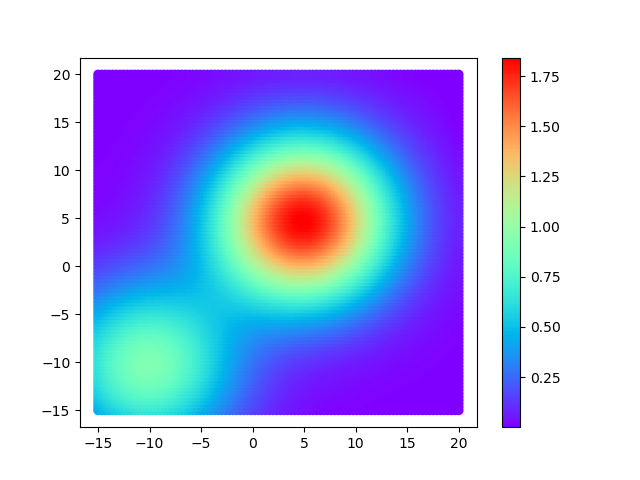

In [13]:
my_size=100
my_test_data = np.zeros([my_size*my_size,2])

for i in range(my_size):
    for j in range(my_size):
        my_test_data[i*my_size+j][0]=template[j]
        my_test_data[i*my_size+j][1]=template[i]
        
start_time = time.time()
μ5, Σ5 = GP(my_training_data_xy, my_training_data_z, my_test_data, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ5 = np.sqrt(np.diag(Σ5))
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
# Draw some samples of the posterior
z5 = np.random.multivariate_normal(mean=μ5, cov=Σ5, size=5)
sel_model = 0
print("--- %s seconds ---" % (time.time() - start_time))

# For Painting
my_draw_test_data_x = my_test_data[:,0].reshape(my_size*my_size,1)
my_draw_test_data_y = my_test_data[:,1].reshape(my_size*my_size,1)
my_test_predict = z5[sel_model].reshape(my_size*my_size,1)

fig, ax = plt.subplots()
sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict, cmap='rainbow', vmin = _min, vmax = _max)
plt.colorbar()
plt.savefig("GP_result_2.png")
plt.show()

In [14]:
'''
 Check Predict Error with Random training sample
'''
import math
# z - my_test_predict

def square(my_list):
    return [ x**2 for x in my_list ]

math.sqrt(sum(square(z-my_test_predict))/training_data_size)

0.018111759295337412

<IPython.core.display.Javascript object>


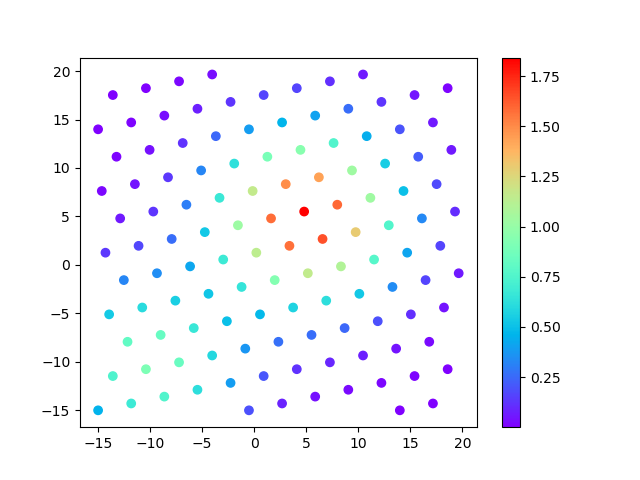

In [15]:
training_data_size = 121
# Generate an empty Space for storage random data
my_training_data_xy = np.zeros([training_data_size, 2])
my_training_data_z = np.zeros(training_data_size)
step = int(real_data_size/training_data_size)
for i in range(training_data_size):
    index = i*step
    my_training_data_xy[i][0] = my_data[index][1]
    my_training_data_xy[i][1] = my_data[index][0]
    my_training_data_z[i] = z[i*step]

# Reshape For Painting
x_d = my_training_data_xy[:,0].reshape(training_data_size,1)
y_d = my_training_data_xy[:,1].reshape(training_data_size,1)
z_d = my_training_data_z.reshape(training_data_size,1)
    
# Draw training data
fig, ax = plt.subplots()
sc = plt.scatter(x_d, y_d, c=z_d, cmap='rainbow', vmin = _min, vmax = _max)
# for i in range(len(z_d)):
#     ax.annotate(z_d[i], xy=(x_d[i],y_d[i]), color='black', 
#             xytext=(5,5), textcoords="offset points")
plt.colorbar()
plt.savefig("Samples_uniform.png")
plt.show()

C:\Users\A70283\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


--- 1.7712600231170654 seconds ---
--- 134.3684687614441 seconds ---


<IPython.core.display.Javascript object>


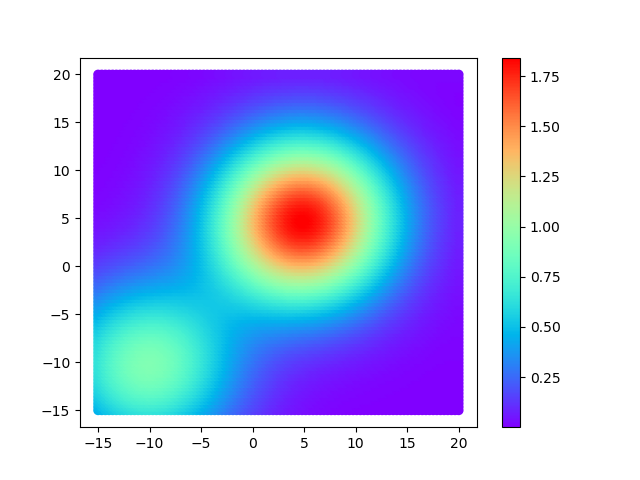

In [18]:
my_size=100
my_test_data = np.zeros([my_size*my_size,2])

for i in range(my_size):
    for j in range(my_size):
        my_test_data[i*my_size+j][0]=template[j]
        my_test_data[i*my_size+j][1]=template[i]
        
start_time = time.time()
μ5, Σ5 = GP(my_training_data_xy, my_training_data_z, my_test_data, exponentiated_quadratic)
# Compute the standard deviation at the test points to be plotted
σ5 = np.sqrt(np.diag(Σ5))
print("--- %s seconds ---" % (time.time() - start_time))

# Draw some samples of the posterior
start_time = time.time()
z5 = np.random.multivariate_normal(mean=μ5, cov=Σ5, size=5)
print("--- %s seconds ---" % (time.time() - start_time))
sel_model = 0

# For Painting
my_draw_test_data_x = my_test_data[:,0].reshape(my_size*my_size,1)
my_draw_test_data_y = my_test_data[:,1].reshape(my_size*my_size,1)
my_test_predict = z5[sel_model].reshape(my_size*my_size,1)

fig, ax = plt.subplots()
sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict, cmap='rainbow', vmin = _min, vmax = _max)
plt.colorbar()
plt.savefig("GP_result_3.png")
plt.show()

In [16]:
'''
 Check Predict Error with Random training sample
'''
import math
# z - my_test_predict

def square(my_list):
    return [ x**2 for x in my_list ]

math.sqrt(sum(square(z-my_test_predict))/training_data_size)

0.018111759295337412

In [135]:
'''
Extract Real Data
'''
my_data = np.genfromtxt('mag_data_x.csv', delimiter=',')

from PIL import Image

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

mag_training_data_xy = []
mag_training_data_z = []
for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            mag_training_data_xy.append([i, j])
            mag_training_data_z.append(my_data[i][j])
mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)

In [188]:
'''
Generate Test data XY
'''
resoultion = 

def range_def(training_data_xy):
    max_x = max(training_data_xy[:,0])
    min_x = min(training_data_xy[:,0])
    max_y = max(training_data_xy[:,1])
    min_y = min(training_data_xy[:,1])
    return max_x, min_x, max_y, min_y

range_def(mag_training_data_xy[0:30])



(31, 26, 134, 63)

In [156]:
mag_test_data = np.zeros([10*10,2])
xxx = np.linspace(0, g_width, 10)
yyy = np.linspace(0, g_height, 10)

for i in range(10):
    for j in range(10):
        mag_test_data[i*10+j][0]=yyy[i]
        mag_test_data[i*10+j][1]=xxx[j]

start_time = time.time()
μ6, Σ6 = GP(mag_training_data_xy[0:30], mag_training_data_z[0:30], mag_test_data, exponentiated_quadratic)
σ5 = np.sqrt(np.diag(Σ5))
print("--- %s seconds ---" % (time.time() - start_time))

# Draw some samples of the posterior
start_time = time.time()
z5 = np.random.multivariate_normal(mean=μ5, cov=Σ5, size=5)
print("--- %s seconds ---" % (time.time() - start_time))
sel_model = 0

C:\Users\A70283\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: LinAlgWarning: Ill-conditioned matrix (rcond=3.23091e-17): result may not be accurate.
C:\Users\A70283\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


--- 0.010944604873657227 seconds ---
--- 136.76166081428528 seconds ---


In [146]:
# For Painting
my_draw_test_data_x = mag_test_data[:,0].reshape(10*my_size,1)
my_draw_test_data_y = mag_test_data[:,1].reshape(my_size*my_size,1)
my_test_predict = z5[sel_model].reshape(my_size*my_size,1)

fig, ax = plt.subplots()
sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict, cmap='rainbow', vmin = _min, vmax = _max)
plt.colorbar()
plt.savefig("GP_result_3.png")
plt.show()

array([[  0.        ,   0.        ],
       [  0.        ,   1.00621118],
       [  0.        ,   2.01242236],
       ...,
       [132.        , 159.98757764],
       [132.        , 160.99378882],
       [132.        , 162.        ]])